# Module 02: Modeling Process

## Prerequisites

This module leverages the following packages.

In [92]:
# Helper packages
import numpy as np
import pandas as pd
import math
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle

# Modeling process
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score

Data used:

In [93]:
# Ames housing data
ames = pd.read_csv("../data/ames.csv")

# Job attrition data
attrition = pd.read_csv("../data/attrition.csv")

## Data splitting

### Simple random sampling

In [94]:
# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# dimensions of training data
train.shape

(2051, 81)

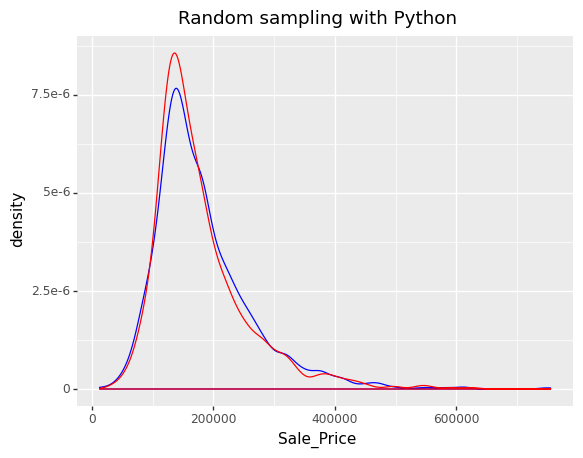

<ggplot: (315836070)>

In [95]:
(ggplot(train, aes('Sale_Price'))
 + geom_density(color = "blue")
 + geom_density(data = test, color = "red")
 + ggtitle("Random sampling with Python"))

### Stratified sampling

In [96]:
y = attrition["Attrition"]
train_strat, test_strat = train_test_split(attrition, train_size=0.3, random_state=123, stratify=y)

In [97]:
# response distribution for raw data
attrition["Attrition"].value_counts(normalize=True)

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

In [98]:
# response distribution for training data
train_strat["Attrition"].value_counts(normalize=True)

No     0.839002
Yes    0.160998
Name: Attrition, dtype: float64

In [99]:
# response distribution for test data
test_strat["Attrition"].value_counts(normalize=True)

No     0.838678
Yes    0.161322
Name: Attrition, dtype: float64

## Creating models

In [100]:
# separate features from labels
X_train = train[["Gr_Liv_Area", "Year_Built"]]
y_train = train["Sale_Price"]

# fit a KNN regression model with 10 neighbors
knn = KNeighborsRegressor(n_neighbors=10)
m1 = knn.fit(X_train, y_train)

m1

KNeighborsRegressor(n_neighbors=10)

In [101]:
m1.predict(X_train)

array([203900. , 129440. , 147725. , ..., 342814.3, 183370. , 142476.9])

## Evaluating models

### Regression model

In [102]:
pred = m1.predict(X_train)

# compute MSE
mse = mean_squared_error(y_train, pred)
mse

1848235388.3486347

In [103]:
# compute RMSE
math.sqrt(mse)

42991.10824750433

### Classification model

In [104]:
# convert response to binary ints
train_strat["Attrition"].replace(('Yes', 'No'), (1, 0), inplace=True)

# separate features from labels
X_train_strat = train_strat[["DistanceFromHome"]]
y_train_strat = np.array(train_strat["Attrition"])

# fit a KNN regression model with 10 neighbors
knn2 = KNeighborsClassifier(n_neighbors=10)
m2 = knn2.fit(X_train_strat, y_train_strat)

# make predictions
pred = m2.predict_proba(X_train_strat)

# compute AUC
roc_auc_score(y_train_strat, pred[:, 1])

0.6159497525694708

## Resampling

In [105]:
# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# fit model with 10-fold CV
results = cross_val_score(m1, X_train, y_train, cv=kfold, scoring=loss)
results

array([-45136.20437337, -38183.69975476, -54169.69935913, -45007.8848804 ,
       -43120.93684721, -51383.34925249, -44315.09008126, -44256.86347971,
       -46078.66311132, -56890.28665348])

In [106]:
results.mean()

-46854.26777931303

In [107]:
# 10 fold cross validation repated 5 times (total of 50 folds)
rfk = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
results = cross_val_score(m1, X_train, y_train, cv=rfk, scoring=loss)
results

array([-45136.20437337, -38183.69975476, -54169.69935913, -45007.8848804 ,
       -43120.93684721, -51383.34925249, -44315.09008126, -44256.86347971,
       -46078.66311132, -56890.28665348, -40017.91401001, -45828.46114923,
       -47228.29689018, -46574.38484149, -52644.55477255, -42413.80172089,
       -50421.09806576, -56747.68115255, -37440.54107935, -51244.11410457,
       -47842.19983968, -41151.85985034, -42691.52559651, -50722.75189446,
       -44479.58978808, -58290.46500997, -57282.16096375, -47068.2904626 ,
       -39169.01810308, -46384.66365693, -45112.38095102, -48230.91228952,
       -43541.52791392, -55709.18621144, -41914.9680488 , -47147.05729334,
       -50511.91358351, -47055.73545207, -47265.80563254, -47956.27164465,
       -54570.55728204, -43444.77925654, -50092.81342186, -39060.25044936,
       -54300.45851559, -45321.71952644, -39325.38043486, -53356.9202388 ,
       -49735.05010088, -45332.77656026])

In [108]:
# average RMSE across all 50 folds
results.mean()

-47263.450311050954

## Hyperparameter tuning

In [109]:
# basic model object
knn = KNeighborsRegressor()

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(2, 26)}

# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

46635.769325114525

In [110]:
# Best model's k value
results.best_estimator_.get_params().get('n_neighbors')

13

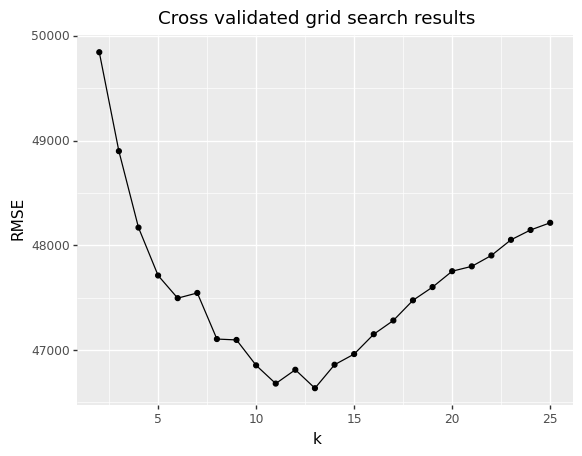

<ggplot: (315103461)>

In [111]:
# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

## Putting the processes together

In [112]:
# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.select_dtypes(include='number').drop("Sale_Price", axis=1)
y_train = train["Sale_Price"]

# create KNN model object
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(2, 26)}

# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

41915.408581298376

In [113]:
# Best model's k value
results.best_estimator_.get_params().get('n_neighbors')

5

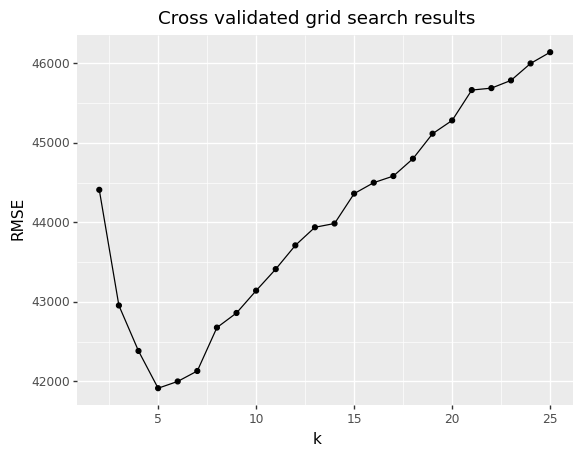

<ggplot: (316934551)>

In [115]:
# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

## Exercises

1. Load the Boston housing data set and split it into a training set and test set using a 70-30% split.

   - How many observations are in the training set and test set?
   - Compare the distribution of `cmedv` between the training set and test set.

2. Fit a KNN model where $k=5$ that uses all available features to predict `cmedv`. How does the MSE/RMSE compare across these models?

3. Perform a 10-fold cross-validated KNN model, repeated 5 times, that uses all available features to predict `cmedv`. 

   - What is the average RMSE across all 50 model iterations?
   - Plot the distribution of the RMSE across all 50 model iterations.
   - Describe the results.

4. Now perform a hyperparameter grid search where _k_ ranges from 2--20 and apply 10-fold CV repeated 5 times.